# ST-GAT Traffic Speed Prediction with Partial Sensor Network
by Da Lei

We will walk through the following steps: 
1.   Installation and Setup
2.   Creating a dataloader
3.   Building the Model
4.   Creating train and evaluation functions
5.   Train the model
6.   Test the model



## Installation and setup

In [ ]:
!pip install -Uqq ipdb
import ipdb

     |████████████████████████████████| 793 kB 35.6 MB/s 
     |████████████████████████████████| 1.6 MB 34.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


We recommend using a GPU for running our project.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
print(torch.__version__)

c:\Users\great\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu
1.12.1


Install PyTorch, PyG, and other necessary python libraries

In [ ]:
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install wget

Mount google for output directories

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd '/content/'
!git clone https://github.com/jswang/stgat_traffic_prediction.git
# %cd stgat_traffic_prediction

'git' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
%cd stgat_traffic_prediction # cd afer delete utils folder

In [14]:
%ls

 Volume in drive D is New Volume
 Volume Serial Number is E21E-AA53

 Directory of d:\research_projects\ST_GAT_Traffic_Speed_Prediction_with_Partial_Sensor_Network

2022/09/04  17:49    <DIR>          .
2022/09/02  15:44    <DIR>          ..
2022/09/02  19:23    <DIR>          __pycache__
2022/09/02  15:46         1,343,123 00_DataPreprocessing.ipynb
2022/09/04  17:48            43,006 01_ST_GAT_Traffic_Speed_Prediction_with_Partial_Sensor_Network_(Kowlong).ipynb
2022/09/04  17:54            90,786 02_LA_case.ipynb
2022/09/04  17:53    <DIR>          dataset
2022/05/16  21:58             1,440 feature_propagation.py
2022/05/16  21:58             2,379 filling_strategies.py
2022/09/04  17:27    <DIR>          processed
2022/09/04  17:40    <DIR>          raw
2022/05/16  21:58             1,913 utils.py
               6 File(s)      1,482,647 bytes
               6 Dir(s)  1,484,652,904,448 bytes free


## Creating a Dataloader
Now, we create a dataloader which will process data from `.csv` files into a PyTorch Geometric dataset. 

In [2]:
import torch
import numpy as np
import pandas as pd
import os
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile
from filling_strategies import filling
from utils import get_missing_feature_mask

# ipdb.set_trace()

def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
      W[W>0] = 1
      W += np.identity(n)

    return W

class TrafficDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """
    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        # ipdb.set_trace()
        super().__init__(root, transform, pre_transform) # would call __init__ of Class InMemoryDataset
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'PeMSD7_V_228.csv')]

    @property
    def processed_file_names(self):
        return ['./data.pt']

    def download(self):
        copyfile('./dataset/PeMSD7_V_228.csv', os.path.join(self.raw_dir, 'PeMSD7_V_228.csv'))

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        # ipdb.set_trace()
        data = pd.read_csv(self.raw_file_names[0], header=None).values

        # Technically using the validation and test datasets here, but it's fine, would normally get the
        # mean and std_dev from a large dataset
        mean =  np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))

        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        edge_index_ls_o = []
        edge_index_ls_d = []
        edge_attr = []
        for i in range(n_node):
          for j in range(n_node):
            if self.W[i,j] != 0:
              edge_index_ls_o.append(i)
              edge_index_ls_d.append(j)
              edge_attr.append(self.W[i,j])
        edge_index = torch.tensor([edge_index_ls_o, edge_index_ls_d], dtype=torch.long)
        edge_attr = torch.tensor(edge_attr).resize_(edge_index.shape[1], 1)

        # another faster version for: adj matrix to edge_index
        # adj_t = torch.tensor([[0,1,0,0],[1,0,0,0], [1,0,0,1], [0,0,1,0]])
        # edge_index = adj_t.nonzero().t().contiguous()

        # >>> tensor([[0, 1, 2, 2, 3],
        #             [1, 0, 0, 3, 2]])

        # # Below is the original version for generating edge_index and edge_attr 
        # # manipulate nxn matrix into 2xnum_edges
        # edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        # # create an edge_attr matrix with our weights  (num_edges x 1) --> our edge features are dim 1
        # edge_attr = torch.zeros((n_node**2, 1))
        # num_edges = 0
        # for i in range(n_node):
        #     for j in range(n_node):
        #         if self.W[i, j] != 0.:
        #             edge_index[0, num_edges] = i
        #             edge_index[1, num_edges] = j
        #             edge_attr[num_edges] = self.W[i, j]
        #             num_edges += 1
        # ipdb.set_trace()
        # # using resize_ to just keep the first num_edges entries
        # edge_index = edge_index.resize_(2, num_edges)
        # edge_attr = edge_attr.resize_(num_edges, 1)

        # randomly remove all of a nodes features
        missing_feature_mask = get_missing_feature_mask(rate=0.4, n_nodes=n_node, n_features = self.config['N_HIST'], type="structural")
        

        sequences = []
        # T x F x N
        for i in range(self.config['N_DAYS']):
            for j in range(self.config['N_SLOT']):
                # for each time point construct a different graph with data object
                # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
                g = Data()
                g.__num_nodes__ = n_node

                g.edge_index = edge_index
                g.edge_attr  = edge_attr

                # (F,N) switched to (N,F)
                sta = i * self.config['N_DAY_SLOT'] + j
                end = sta + n_window
                # [21, 228]

                full_window = np.swapaxes(data[sta:end, :], 0, 1) # https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html
                x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
                x[~missing_feature_mask] = float("nan") # filling missing position using nan
                filled_feature = filling("feature_propagation", edge_index, x, missing_feature_mask, num_iterations=40)

                x = torch.where(missing_feature_mask, x, filled_feature)

                g.x = x
                g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
                sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)
        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])

def get_splits(dataset: TrafficDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: TrafficDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test


In [ ]:
get_missing_feature_mask(rate=0.3, n_nodes=20, n_features = 12, type="structural").shape

torch.Size([20, 12])

#Build the Model

Using PyG's built in layers, create a Spatio-Temporal Graph as presented in https://ieeexplore.ieee.org/document/8903252. 

Ths model is a Pytorch model containing an initialization function for setting up the model architecture, and a forward function for performing a forward pass of data through the model.

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        self.n_preds = 9
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index = data.x, data.edge_index
        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        # [12, 50, 228] -> [12, 50, 32]
        x, _ = self.lstm1(x)
        # [12, 50, 32] -> [12, 50, 128]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 128] -> [50, 128]
        x = torch.squeeze(x[-1, :, :])
        # [50, 128] -> [50, 228*9]
        x = self.linear(x)

        # Now reshape into final output
        s = x.shape
        # [50, 228*9] -> [50, 228, 9]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        # [50, 228, 9] ->  [11400, 9]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        return x


##Create Train and Evaluation functions

Create a train function which performs a forward and a backward pass using the model.

Create an evaluation function which performs only a forward pass using the model.

These functions will be used in various stages of overall model training and testing.

In [4]:
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n

    print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

    #get the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

In order to evaluation the performance of the model, we need to define some evaluation metrics.  

*   The Z-score normalizes data using mean and std deviation.
*   MAPE is mean average percentage error. 
*   RMSE is root mean square error.
*   MAE is mean absolute error. 





In [5]:
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))


Now, let's put it all together. Let's use the `train` and `eval` functions along with the model and dataloadres to create a training function (`model_train`) and testing function (`model_test`).

We also build in tensorboard support for logging of the training metrics over time.


In [7]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    model.to(device)

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


##Start training

Now with all code in place, let's set up config, load our dataset, and start training!

First, to watch your training over time, load the tensorboard extension

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./runs

Now, create your dataloaders and start training!

In our default configuration, we train for 60 epochs with a batch size of 50. You can view your training progress in the tensorboard above by clicking the "refresh" button to see new data. Training and validation performance are updated every 5 epochs.

In [17]:
from torch_geometric.loader import DataLoader

# Constant config to use throughout
config = {
    'BATCH_SIZE': 50,
    'EPOCHS': 60,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 9,
    'N_HIST': 12,
    'DROPOUT': 0.2,
    # number of possible 5 minute measurements per day
    'N_DAY_SLOT': 288,
    # number of days worth of data in the dataset
    'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 228,
}
# Number of possible windows in a day
config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1

# Load the weight and dataset dataset
distances = pd.read_csv('./dataset/PeMSD7_W_228.csv', header=None).values
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
dataset = TrafficDataset(config, W)

# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (34, 5, 5))
train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Get gpu if you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

# Configure and train model
config['N_NODE'] = dataset.n_node
model = model_train(train_dataloader, val_dataloader, config, device)

Processing...


KeyboardInterrupt: 

## Test the model

Now that we have a trained model, we can test it on the test dataset and visualize its performance

Test, MAE: 3.971902847290039, RMSE: 6.542290687561035, MAPE: 9.678857803344727


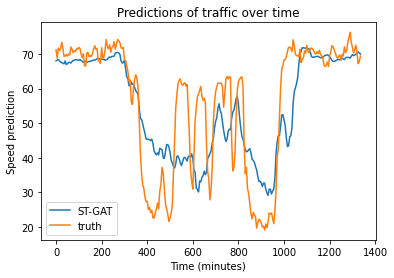

In [ ]:
def plot_prediction(test_dataloader, y_pred, y_truth, node, config):
    # Calculate the truth
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_truth = y_truth[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_truth = torch.flatten(y_truth)
    day0_truth = y_truth[:config['N_SLOT']]


    # Calculate the predicted
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_pred = y_pred[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_pred = torch.flatten(y_pred)
    # Just grab the first day
    day0_pred = y_pred[:config['N_SLOT']]
    t = [t for t in range(0, config['N_SLOT']*5, 5)]
    plt.plot(t, day0_pred, label='ST-GAT')
    plt.plot(t, day0_truth, label='truth')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Speed prediction')
    plt.title('Predictions of traffic over time')
    plt.legend()
    plt.savefig('predicted_times.png')
    plt.show()
    
_, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
plot_prediction(test_dataloader, y_pred, y_truth, 0, config)

## Rejoice

We hope that you have found this colab informative and useful. Note that our final performance lags that published by the paper slightly, we believe this is due to small differences in training parameters and initializations that were not published with the paper.

In [ ]:
%cd stgat_traffic_prediction

/content/stgat_traffic_prediction
